In [2]:
# Torch version: 2.0.1
# TorchVision version: 0.16.0


import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

In [3]:
project_name='bird-species'


In [4]:
# Look into the directory
data_dir = 'C:/Users/dongz/Desktop/02476/archive'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes[:10])
print(len(classes))

['birds.csv', 'EfficientNetB0-525-(224 X 224)- 98.97.h5', 'test', 'train', 'valid']
['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS']
525


In [5]:
# Data transforms (normalization & data augmentation)
transformations = transforms.Compose([
                        transforms.Resize((128, 128)),
                        transforms.ToTensor(),
                       ])

In [7]:
# Data transforms (normalization & data augmentation)
transformations = transforms.Compose([
                        transforms.Resize((128, 128)),
                        transforms.ToTensor(),
                       ])

In [8]:
# PyTorch datasets
dataset = ImageFolder(data_dir+'/train', transform=transformations)
test = ImageFolder(data_dir+'/test', transform=transformations)
valid = ImageFolder(data_dir+'/valid', transform=transformations)

In [9]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 128, 128]) 0


tensor([[[0.9333, 0.9294, 0.9176,  ..., 0.3529, 0.3294, 0.3255],
         [0.9294, 0.9255, 0.9137,  ..., 0.3647, 0.3333, 0.3373],
         [0.9255, 0.9216, 0.9176,  ..., 0.4039, 0.3608, 0.3451],
         ...,
         [0.4275, 0.4549, 0.5255,  ..., 0.1608, 0.1725, 0.1804],
         [0.4196, 0.4431, 0.4941,  ..., 0.1608, 0.1647, 0.1765],
         [0.4353, 0.4510, 0.4941,  ..., 0.1569, 0.1608, 0.1725]],

        [[0.9333, 0.9333, 0.9255,  ..., 0.3059, 0.2824, 0.2784],
         [0.9294, 0.9294, 0.9216,  ..., 0.3255, 0.2902, 0.2863],
         [0.9255, 0.9216, 0.9216,  ..., 0.3725, 0.3176, 0.2941],
         ...,
         [0.5725, 0.5843, 0.6196,  ..., 0.1647, 0.1686, 0.1725],
         [0.5686, 0.5725, 0.5961,  ..., 0.1647, 0.1647, 0.1725],
         [0.5843, 0.5843, 0.6000,  ..., 0.1647, 0.1647, 0.1725]],

        [[0.8980, 0.8941, 0.8824,  ..., 0.2588, 0.2353, 0.2157],
         [0.8902, 0.8902, 0.8745,  ..., 0.2353, 0.2275, 0.2431],
         [0.8824, 0.8745, 0.8706,  ..., 0.2314, 0.2353, 0.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  ABBOTTS BABBLER (0)


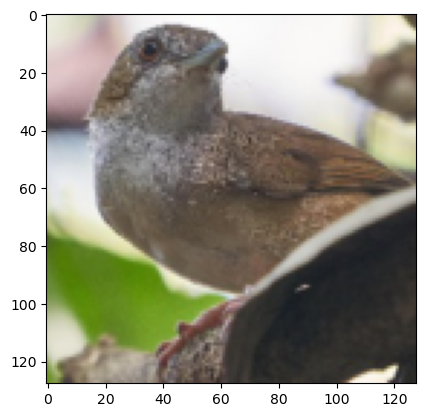

In [11]:
img, label = dataset[0]
show_example(img, label)

Label:  ABBOTTS BABBLER (0)


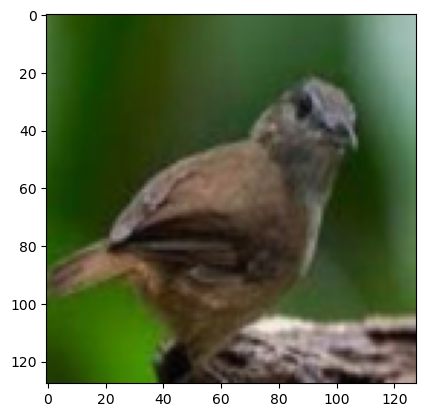

In [12]:
show_example(*dataset[155])


In [13]:
random_seed = 42
torch.manual_seed(random_seed);

In [14]:
len(dataset)


84635

In [15]:
len(valid)


2625

In [16]:

val_size = 1000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(83635, 1000)

In [17]:
batch_size= 32

In [18]:
# Pytorch Dataloaders

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

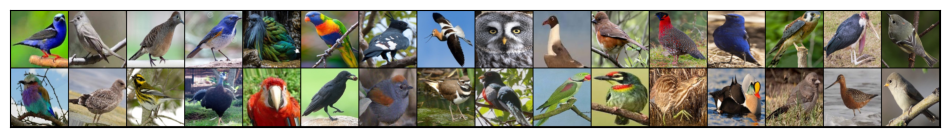

In [19]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break
show_batch(train_dl)

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [21]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 525)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [22]:
model = ResNet()
model


c:\Users\dongz\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dongz\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [23]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([32, 3, 128, 128])
out.shape: torch.Size([32, 525])
out[0]: tensor([0.5469, 0.4282, 0.4247, 0.4020, 0.3517, 0.2282, 0.4158, 0.5982, 0.3525,
        0.3155, 0.6781, 0.3998, 0.4136, 0.5076, 0.5801, 0.4259, 0.4869, 0.7426,
        0.2536, 0.6173, 0.7470, 0.7828, 0.6232, 0.5214, 0.6348, 0.3271, 0.5385,
        0.5573, 0.6664, 0.4148, 0.3652, 0.4907, 0.5126, 0.3874, 0.5337, 0.6089,
        0.6005, 0.2210, 0.3175, 0.5625, 0.4011, 0.3988, 0.5998, 0.6192, 0.4626,
        0.5575, 0.7209, 0.3497, 0.3253, 0.6635, 0.4101, 0.6346, 0.4491, 0.7120,
        0.2314, 0.3838, 0.2977, 0.4205, 0.4687, 0.5603, 0.4249, 0.4664, 0.4535,
        0.4617, 0.3661, 0.7028, 0.5665, 0.2128, 0.5651, 0.6786, 0.3322, 0.3166,
        0.4893, 0.3116, 0.3740, 0.6894, 0.5866, 0.5096, 0.3499, 0.6700, 0.1863,
        0.4387, 0.6324, 0.3055, 0.6416, 0.4928, 0.4891, 0.5305, 0.5384, 0.5454,
        0.5369, 0.5632, 0.3181, 0.4704, 0.6802, 0.5182, 0.3812, 0.5627, 0.3632,
        0.3279, 0.3245, 0.5325, 0.4

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(ResNet(), device)

In [29]:
evaluate(model, val_dl)

{'val_loss': 6.283000946044922, 'val_acc': 0.0}

In [30]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 5.5e-5

In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 5.5185, val_loss: 5.3360, val_acc: 0.7695
Epoch [1], train_loss: 5.3238, val_loss: 5.3088, val_acc: 0.7994
Epoch [2], train_loss: 5.3008, val_loss: 5.3064, val_acc: 0.7941
Epoch [3], train_loss: 5.2914, val_loss: 5.2982, val_acc: 0.8051
Epoch [4], train_loss: 5.2880, val_loss: 5.2983, val_acc: 0.8289


In [32]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

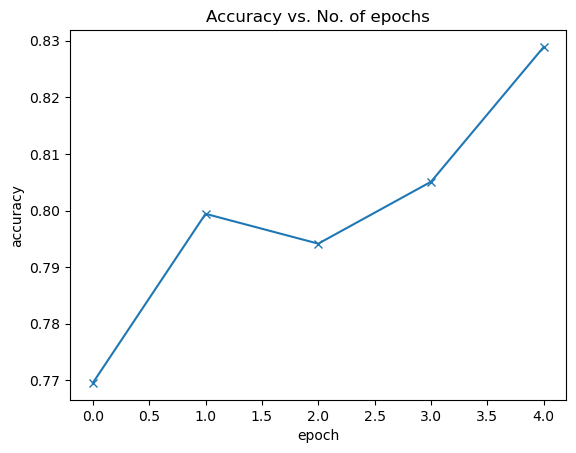

In [33]:
plot_accuracies(history)

In [34]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

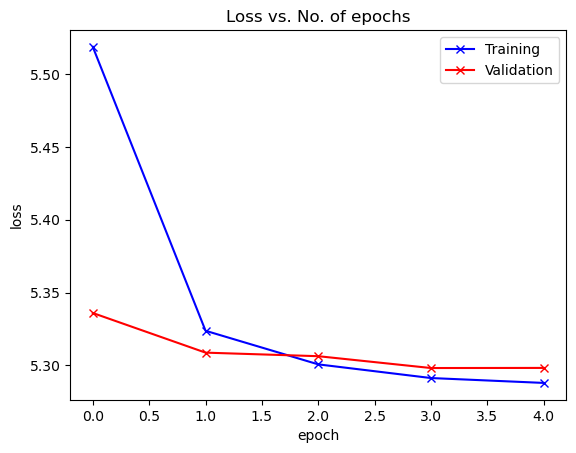

In [35]:
plot_losses(history)

In [36]:
test_dataset = ImageFolder(data_dir+'/test', transform=transformations)

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: ABBOTTS BABBLER , Predicted: ABBOTTS BABBLER


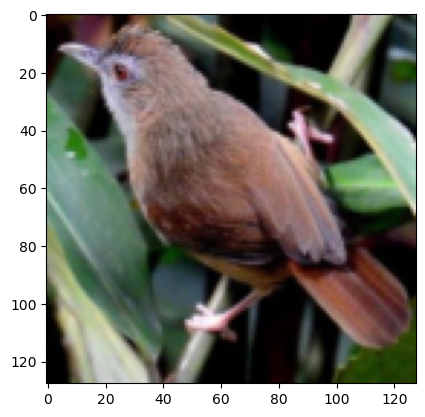

In [38]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: AMERICAN KESTREL , Predicted: AMERICAN KESTREL


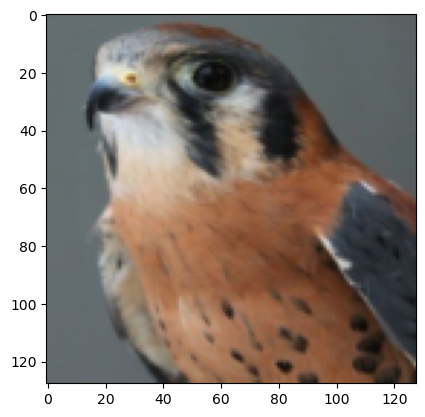

In [39]:
img, label = test_dataset[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [40]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 5.284841060638428, 'val_acc': 0.8705357313156128}